In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import MinMaxScaler 
from keras.layers import Dense, GRU
from keras.metrics import MeanSquaredError
from keras.models import Sequential 
from keras.optimizers.legacy import SGD

### 1. 데이터 불러오기

- 데이터 병합
- 데이터 전처리

In [92]:
data_amex  = pd.read_csv('./dataset/amex_data.csv')
data_nsdq = pd.read_csv('./dataset/nasdaq_data.csv')
data_nyse = pd.read_csv('./dataset/nyse_data.csv')
data = pd.concat([data_amex, data_nsdq, data_nyse])
data = data.drop(columns=['Unnamed: 0'])
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_values(by=['Date', 'symbol'])
data = data[['symbol','Adj Close','Open','High','Low',"Close","Volume"]]
data.head()

,symbol,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,,
1962-01-02,AEP,0.98161,0.00000,35.12500,34.31250,34.31250,5800.00000
1962-01-02,GT,1.95176,0.00000,11.18750,11.00000,11.12500,32000.00000
1962-01-02,HON,1.08628,0.00000,8.32874,8.27260,8.31003,40740.00000
1962-01-02,XRX,0.85624,0.00000,4.71380,4.65525,4.68453,51233.00000
1962-01-03,AEP,0.97982,0.00000,34.75000,34.06250,34.25000,10200.00000


In [94]:
df_21 = data[data.index.year == 2021]
df_21.head()

,symbol,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,,
2021-01-04,AACG,1.18000,1.17000,1.22000,1.17000,1.18000,18000.00000
2021-01-04,AADI,15.75000,14.92500,16.05000,14.58000,15.75000,373920.00000
2021-01-04,AAL,15.13000,15.85000,15.88000,15.03000,15.13000,69732500.00000
2021-01-04,AAME,2.09366,2.14000,2.18000,2.06000,2.14000,298100.00000
2021-01-04,AAOI,8.76000,8.58000,8.97000,8.49000,8.76000,782800.00000


In [95]:
df_22 = data[data.index.year == 2022]
df_22.head()

,symbol,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,,
2022-01-03,AACG,1.19000,1.17000,1.31000,1.15000,1.19000,127700.00000
2022-01-03,AACI,9.91000,9.81000,9.91000,9.81000,9.91000,112300.00000
2022-01-03,AACIU,10.15000,10.10000,10.15000,10.10000,10.15000,1200.00000
2022-01-03,AADI,24.97000,24.46000,25.00000,23.67000,24.97000,62000.00000
2022-01-03,AAL,18.75000,18.23000,19.18000,18.20000,18.75000,42781000.00000


### 2. 21, 22년도 데이터 추출 및 저장

- 각 주식 symbol에 대한 21년, 22년 데이터 추출
- 추출된 데이터를 개별 csv 파일로 저장

In [96]:
symbol_21 = df_21['symbol'].unique()
symbol_22 = df_22['symbol'].unique()

# 두 데이터프레임에서 공통된 symbol 중 row 수가 일치하는 symbol만 선택합니다.
symbol_total = [
    s for s in symbol_21 if s in symbol_22
    and df_21[df_21['symbol'] == s].shape[0]-1 == df_22[df_22['symbol'] == s].shape[0]
]

# symbol 리스트를 4개로 분할합니다.
n = len(symbol_total)//4
symbol_divided = [symbol_total[i:i + n] for i in range(0, len(symbol_total), n)]

In [ ]:
# data_21과 data_22 폴더가 없다면 생성합니다.
def create_data_folders():
    # data_21과 data_22 폴더가 없다면 생성합니다.
    if not os.path.exists("data_21"):
        os.makedirs("data_21")
    if not os.path.exists("data_22"):
        os.makedirs("data_22")
    
    
def save_symbol_data_to_csv(symbols, df_21, df_22):
    for symbol in symbols:
        # df_21에 대한 CSV 파일 저장
        temp_df_21 = df_21[df_21['symbol'] == symbol]
        file_path_21 = os.path.join("data_21", f"df_21_{symbol}.csv")
        temp_df_21.to_csv(file_path_21, index=False)
        
        # df_22에 대한 CSV 파일 저장
        temp_df_22 = df_22[df_22['symbol'] == symbol]
        file_path_22 = os.path.join("data_22", f"df_22_{symbol}.csv")
        temp_df_22.to_csv(file_path_22, index=False)


# 여기에서 symbols_parts[0], symbols_parts[1] 등으로 분할된 리스트를 사용하여 연산을 수행합니다.
create_data_folders()
save_symbol_data_to_csv(symbol_divided[0], df_21, df_22)  # 첫 번째 부분에 대한 처리
save_symbol_data_to_csv(symbol_divided[1], df_21, df_22)  # 두 번째 부분에 대한 처리 
save_symbol_data_to_csv(symbol_divided[2], df_21, df_22)  # 세 번째 부분에 대한 처리
save_symbol_data_to_csv(symbol_divided[3], df_21, df_22)  # 네 번째 부분에 대한 처리

### 3. GRU 모델 학습 및 2022년 예측

- 각 csv 파일의 데이터를 정규화한 후에 GRU 모델로 학습을 진행
- 학습된 모델로 2022년의 주식 가격을 예측

In [97]:
def ts_train_test_normalize(train_data, test_data, time_steps, for_periods):
    """
    입력: 
        train_data: 훈련 데이터
        test_data: 테스트 데이터
    출력: 
        X_train, y_train: 훈련 데이터
        X_test : 테스트 데이터
        sc : 훈련 데이터에 맞게 인스턴스화된 MinMaxScaler 객체
    """
    # 훈련 및 테스트 데이터를 값으로 변환
    ts_train = train_data.iloc[:,1:2].values
    ts_test = test_data.iloc[:,1:2].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # 데이터 스케일링
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # s 샘플과 t 타임 스텝의 훈련 데이터 생성
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # 효율적인 모델링을 위한 X_train 재구성
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # 입력 데이터 준비
    inputs = np.concatenate((ts_train, ts_test), axis=0)
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # X_test 준비
    X_test = []
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train, X_test, sc

In [98]:
def GRU_model(X_train, y_train, X_test, sc):
    
        
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(learning_rate = 0.01, 
                                         decay = 1e-7, 
                                         momentum = 0.9, 
                                         nesterov = False), 
                         loss = 'mean_squared_error')
    
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, 
                     y_train, 
                     epochs = 50, 
                     batch_size = 150, 
                     verbose = 0)
    
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    
    return my_GRU_model, GRU_prediction 

In [99]:
def train_and_save_models(i, symbol_divided, df_21, df_22):
    # models_21 폴더와 prdcts_22 폴더를 생성합니다.
    os.makedirs("models_21", exist_ok=True)
    os.makedirs("prdcts_22", exist_ok=True)
    
    symbol_cnt = len(symbol_divided)
    
    # symbol 별로 전처리, 학습, 저장
    for idx, symbol in enumerate(symbol_divided):
        print(f"progress:{i+1}/4, processing for symbol: {symbol} ({idx + 1}/{symbol_cnt})")
        
        # 심볼별 csv 파일을 불러옵니다.
        X_file_path = os.path.join("data_21", f"df_21_{symbol}.csv")
        y_file_path = os.path.join("data_22", f"df_22_{symbol}.csv")
        
        if os.path.exists(X_file_path) and os.path.exists(y_file_path):
            X = pd.read_csv(X_file_path)
            y = pd.read_csv(y_file_path)
            
            # 데이터 전처리
            X_train, y_train, X_test, sc = ts_train_test_normalize(X, y, 5, 2)

            # 모델 학습
            model, prdct = GRU_model(X_train, y_train, X_test, sc)

            # 모델을 keras 형식으로 저장
            model.save(os.path.join("models_21", f"model_21_{symbol}.keras"))

            # 예측 결과를 CSV 형식으로 저장
            pd.DataFrame(prdct).to_csv(os.path.join("prdcts_22", f"prdct_22_{symbol}.csv"), index=False)
        else:
            print(f"{symbol}에 해당하는 csv 파일을 찾을 수 없습니다.")


In [ ]:
train_and_save_models(2, symbol_divided[0], df_21, df_22) # 한번에 진행하는 경우 컴퓨터가 다운될 수 있기 때문에 네개로 나누어 진행

In [ ]:
train_and_save_models(2, symbol_divided[1], df_21, df_22)

In [103]:
train_and_save_models(2, symbol_divided[2], df_21, df_22)

progress:3/4, processing for symbol: PTPI (1/41)
8/8 [==============================] - 0s 2ms/step
progress:3/4, processing for symbol: PTRS (2/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PTSI (3/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PTVE (4/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PUBM (5/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PULM (6/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PUYI (7/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PVBC (8/41)
8/8 [==============================] - 0s 2ms/step
progress:3/4, processing for symbol: PW (9/41)
8/8 [==============================] - 1s 1ms/step
progress:3/4, processing for symbol: PW-PA (10/41)


/Users/b06/miniforge3/envs/yeardream/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/b06/miniforge3/envs/yeardream/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PWFL (11/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PWOD (12/41)
8/8 [==============================] - 0s 2ms/step
progress:3/4, processing for symbol: PWP (13/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PXLW (14/41)
8/8 [==============================] - 0s 2ms/step
progress:3/4, processing for symbol: PXS (15/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PXSAP (16/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PYPD (17/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PYPL (18/41)
8/8 [==============================] - 1s 2ms/step
progress:3/4, processing for symbol: PYR (19/41)
8/8 [==============================] - 0s 1ms/step
progress:3/4, processing for symbol: PZG (

In [104]:
train_and_save_models(3, symbol_divided[3], df_21, df_22)

progress:4/4, processing for symbol: QUBT (1/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: QUIK (2/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: QURE (3/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RAIL (4/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RAND (5/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RAPT (6/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RARE (7/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RAVE (8/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RBB (9/742)
8/8 [==============================] - 0s 1ms/step
progress:4/4, processing for symbol: RBBN (10/742)
8/8 [==============================] - 0s

### 4. 성능 평가 및 시각화

- 특정 symbol을 입력값으로 해당 주식의 실제 가격과 예측된 가격을 그래프로 시각화하여 비교
- MAE, RMSE, RMSLE, R^2와 같은 성능 지표를 사용하여 모델의 예측 성능을 평가

In [105]:
def actual_pred_plot(y_test, y_pred):
    """
    실제 값과 예측 값을 그래프로 그립니다.
    :param y_test: 실제 값
    :param y_pred: 예측 값
    :return: Mean Squared Error와 그래프
    """
    actual_pred = pd.DataFrame(columns=['Adj Close', 'prediction'])  # DataFrame 생성
    actual_pred['Adj Close'] = y_test  # 실제 값
    actual_pred['prediction'] = y_pred  # 예측 값

    m = MeanSquaredError()  # MeanSquaredError 인스턴스 생성
    m.update_state(np.array(y_test), np.array(y_pred))  # 상태 업데이트

    plt.figure(figsize=(12, 6))
    plt.plot(actual_pred['Adj Close'], label='Actual')
    plt.plot(actual_pred['prediction'], label='Prediction')
    plt.legend()
    plt.show()

    return m.result().numpy()  # Mean Squared Error 반환

In [106]:
def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

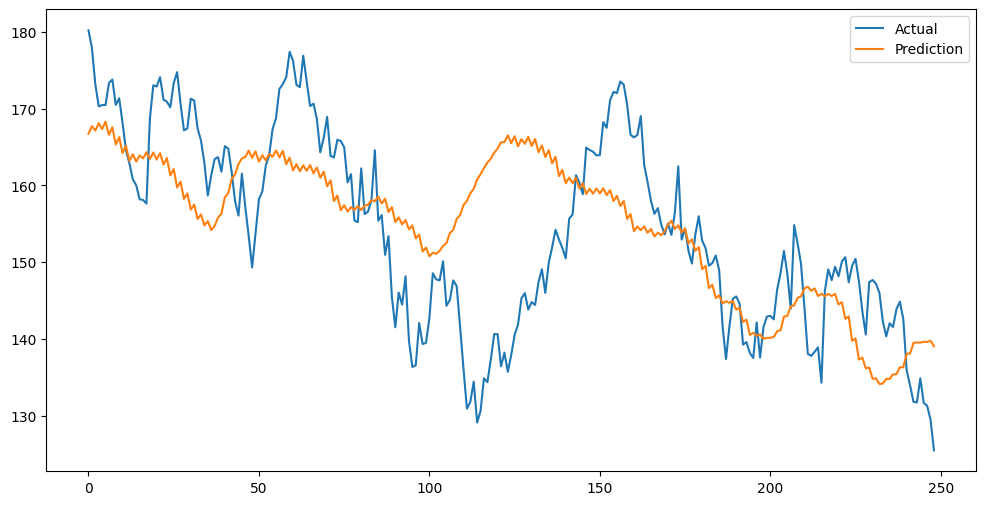

,Results
MAE,8.46973
RMSE,10.85581
RMSLE,0.07088
R2,0.26069


In [107]:
symbol = 'AAPL'
y_pred = pd.read_csv(f'prdcts_22/prdct_22_{symbol}.csv').values.flatten()[:249]
y_test = df_22[df_22['symbol'] == symbol]['Adj Close'].values[:249]

actual_pred_plot(y_test, y_pred)
confirm_result(y_test, y_pred)

In [108]:
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

Length of y_test: 249
Length of y_pred: 249


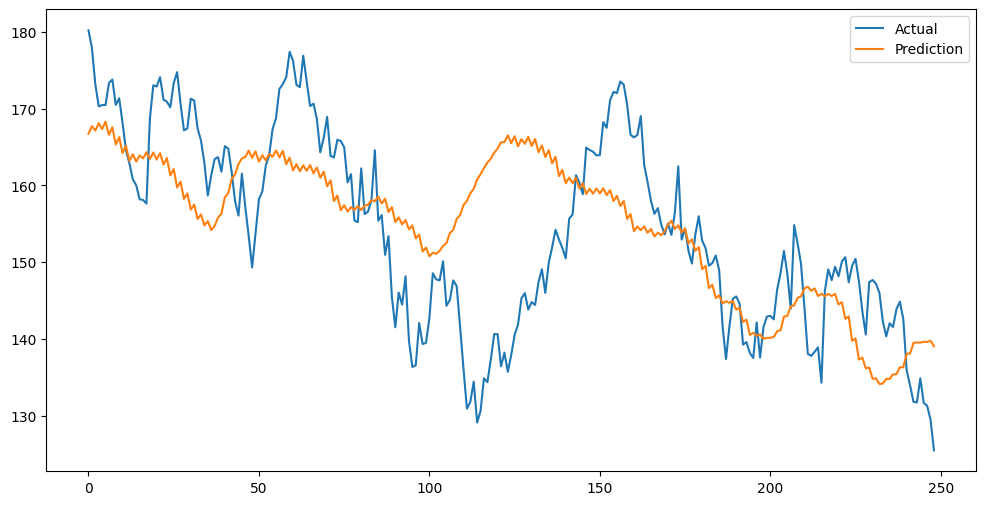

(117.84857,
        Results
 MAE    8.46973
 RMSE  10.85581
 RMSLE  0.07088
 R2     0.26069)

In [109]:
def temp_(symbol):
    y_pred = pd.read_csv(f'prdcts_22/prdct_22_{symbol}.csv').values.flatten()[:249]
    y_test = df_22[df_22['symbol'] == symbol]['Adj Close'].values[:249]
    return actual_pred_plot(y_test, y_pred), confirm_result(y_test, y_pred)

temp_('AAPL')